# Instacart Market Basket Analysis
Instacart에서 제공하는 dataset은 익명화된 20만 이상의 유저로부터 340만 이상의 주문이 포함되어 있습니다.

목표: 타겟은 어떤 제품이 특정 유저의 다음 주문에 포함될지 예측하는 것 입니다.

* Instacart kaggle : https://www.kaggle.com/c/instacart-market-basket-analysis#prizes

## 데이터셋 살펴보기

총 7개의 csv파일이 제공됩니다. 

1. orders.csv (3421083, 7)
2. order_products__priors.csv (32434489, 4)
3. order_products__train.csv (1384617, 4)
4. products.csv (49688, 4)
5. aisles.csv (134, 2)
6. departments.csv (21, 2)
7. sample_submission.csv (75000, 2)

## 라이브러리 및 함수 준비


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
color = sns.color_palette()

# PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/prepared/' # csv파일이 들어있는 폴더 경로 지정
PATH = 'D:/project/해커톤/data/'

In [10]:
# 구글 드라이브 마운트
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
# Annotate text on graph
def annotate_text(p, append_to_text='%'):
    for p in ax.patches:
        txt = str(p.get_height().round(2)) + append_to_text
        txt_x = p.get_x() + p.get_width()/2.
        txt_y = 0.92*p.get_height()
        ax.text(txt_x,txt_y,txt, fontsize=20, color='#004235', ha='center', va='bottom')

## 데이터 로드

In [12]:
# csv 파일 로드 및 메모리 관리를 위한 데이터 타입 지정
priors = pd.read_csv(PATH + 'order_products__prior.csv', dtype={
            'order_id': np.uint32,          # 1 ~ 3421083
            'product_id': np.uint16,        # 1 ~ 49688
            'add_to_cart_order': np.uint8,  # 1 ~ 80 
            'reordered': np.uint8})         # 0 ~ 1
orders = pd.read_csv(PATH + 'orders.csv', dtype={
        'order_id': np.uint32,              # 1 ~ 3421083
        'user_id': np.uint32,               # 1 ~ 206209
        'eval_set': 'category',             # 3가지
        'order_number': np.uint8,           # 1 ~ 100
        'order_dow': np.uint8,              # 0 ~ 6 
        'order_hour_of_day': np.uint8,      # 0 ~ 23
        'days_since_prior_order': np.float32})
products = pd.read_csv(PATH + 'products.csv', dtype={
        'product_id': np.uint16,     # 1 ~ 49688
        'aisle_id': np.uint8,        # 1 ~ 134
        'department_id': np.uint8}) # 1 ~ 21
aisles = pd.read_csv(PATH + 'aisles.csv', dtype={
        'product_id': np.uint16})     # 1 ~ 49688
departments = pd.read_csv(PATH + 'departments.csv', dtype={
        'product_id': np.uint16})
train = pd.read_csv(PATH + 'order_products__train.csv', dtype={
            'order_id': np.uint32,          # 1 ~ 3421083
            'product_id': np.uint16,        # 1 ~ 49688
            'add_to_cart_order': np.uint8,  # 1 ~ 80 
            'reordered': np.uint8})         # 0 ~ 1

### 데이터 합치기

In [13]:
# df에 모든 컬럼을 추가함
df = priors.append(train)
df = df.merge(products, on='product_id', how='left')
df = df.merge(aisles, on='aisle_id', how='left')
df = df.merge(departments, on='department_id', how='left')
df = df.merge(orders, on='order_id', how='outer')
df = df.astype({'product_id': np.float32, 'add_to_cart_order': np.float32, 'reordered': np.float32, 
                'aisle_id': np.float32,'department_id':np.float32, 'product_name' : 'category', 
                'aisle' : 'category', 'department' : 'category'})
col = ['user_id', 'order_number', 'order_id', 'product_id', 'product_name', 'add_to_cart_order', 'reordered', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'aisle_id', 'aisle', 'department_id', 'department', 'eval_set']
df = df[col]
df.sort_values(by=['user_id', 'order_number'], inplace=True, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33894106 entries, 0 to 33894105
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   user_id                 uint32  
 1   order_number            uint8   
 2   order_id                uint32  
 3   product_id              float32 
 4   product_name            category
 5   add_to_cart_order       float32 
 6   reordered               float32 
 7   order_dow               uint8   
 8   order_hour_of_day       uint8   
 9   days_since_prior_order  float32 
 10  aisle_id                float32 
 11  aisle                   category
 12  department_id           float32 
 13  department              category
 14  eval_set                category
dtypes: category(4), float32(6), uint32(2), uint8(3)
memory usage: 1.4 GB


In [14]:
# df 저장
df.to_pickle(PATH + 'EDA.pkl')

In [15]:
# df 불러오기
df = pd.read_pickle(PATH + 'EDA.pkl')

## orders

`orders` 주문에 관련된 정보들을 확인할 수 있다.

* `order_id`: 주문 식별번호
* `user_id`: 고객 식별번호
* `eval_set`: 주문이 속한 데이터 세트
* `order_number`: 해당 유저의 연속 주문에 대한 번호
* `order_dow`: 주문이 발생한 요일
* `order_hour_of_day`: 주문이 발생한 시각
* `days_since_prior`: 이전 주문과의 간격을 나타낸다. 최대 30일까지 나타내며, 첫 주문의 경우 결측치로 되어있다.

In [16]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [17]:
# orders 결측치 확인
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

206,209개의 결측치가 있다. 고객의 첫 주문은 이전 주문에 대한 기록이 없기때문에 `user_id` 숫자만큼의 결측치가 존재한다.

### order_id & user_id

In [18]:
print(f"총 주문 수 : {orders.order_id.nunique()}")
print(f"총 고객 수 : {orders.user_id.nunique()}")

총 주문 수 : 3421083
총 고객 수 : 206209


### eval_set

prior, train, test 세가지로 구분

- prior : 전체 고객의 마지막 주문을 제외한 모든 주문정보가 들어있다.

- train : 131,209명의 마지막 주문정보도 포함한 모든 주문정보가 들어있다.

- test : 75,000명의 마지막 주문. 주문별 구매 내역을 예측해야 한다.

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


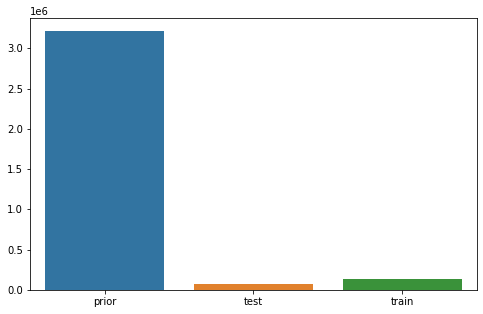

In [19]:
# 타입별 주문 수량 확인
data = orders.eval_set.value_counts()
print(data)
plt.figure(figsize=(8, 5))
sns.barplot(x=data.index, y=data.values)
plt.show()

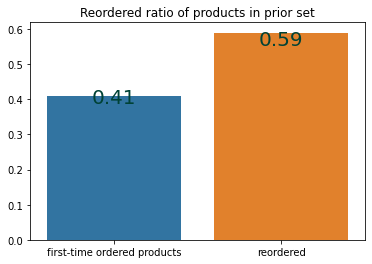

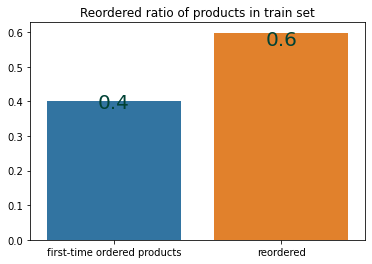

In [20]:
# prior set에서의 전체 주문 중 재주문 비율
total_prod_count = priors.shape[0]
reorder_ratio = priors['reordered'].value_counts()/total_prod_count
ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values)
ax.set_xticklabels(['first-time ordered products', 'reordered'])
annotate_text(ax, append_to_text='')
plt.title('Reordered ratio of products in prior set')
plt.show()

total_prod_count = train.shape[0]
reorder_ratio = train['reordered'].value_counts()/total_prod_count
ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values)
ax.set_xticklabels(['first-time ordered products', 'reordered'])
annotate_text(ax, append_to_text='')
plt.title('Reordered ratio of products in train set')
plt.show()

prior와 train간의 데이터 분포는 큰 차이가 없어보인다.

### order_number

해당 유저의 몇 번째 주문인지 알 수 있다.

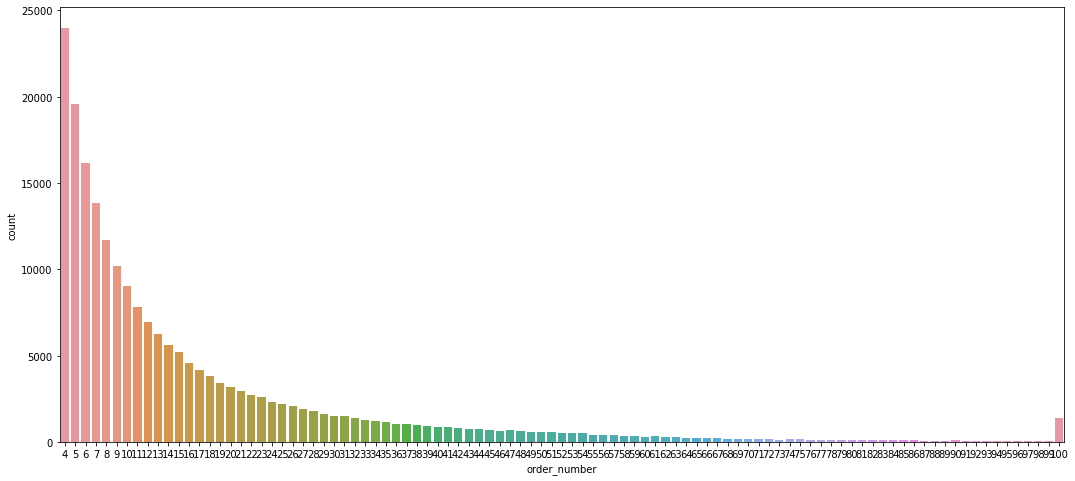

In [21]:
plt.figure(figsize=(18, 8))
data = orders.groupby('user_id')['order_number'].max().reset_index()
sns.countplot(x='order_number', data=data)
plt.show()

In [22]:
orders.groupby('user_id')['order_number'].max().describe()

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_number, dtype: float64

최소 주문 수는 4건, 최대 주문 수는 100건 이상이다.

4번 주문한 고객이 가장 많다.

### order_dow

주문이 발생한 요일로 0~6으로 구분된다.

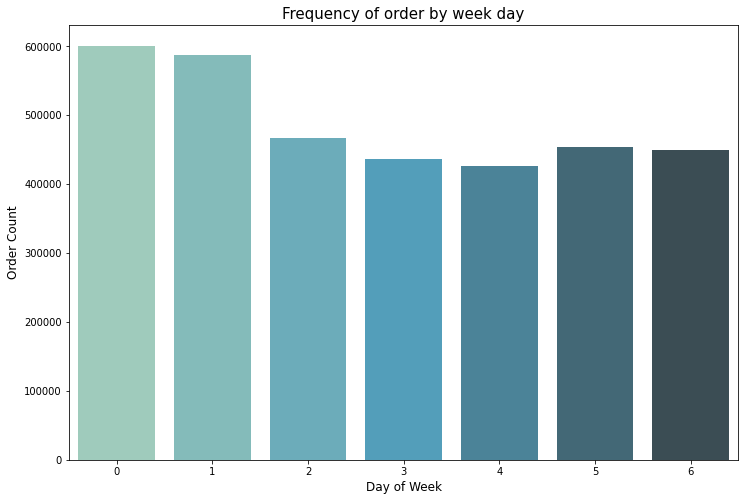

In [23]:
data = orders.groupby('order_id')['order_dow'].aggregate("sum").reset_index()
data = data.order_dow.value_counts()
f, ax = plt.subplots(figsize=(12, 8))

sns.barplot(data.index,data.values,palette='GnBu_d')
plt.title("Frequency of order by week day", fontsize=15)
plt.ylabel('Order Count', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.show()

In [24]:
round(orders.order_dow.value_counts()[:2].mean() / orders.order_dow.value_counts()[2:].mean(), 2)

1.33

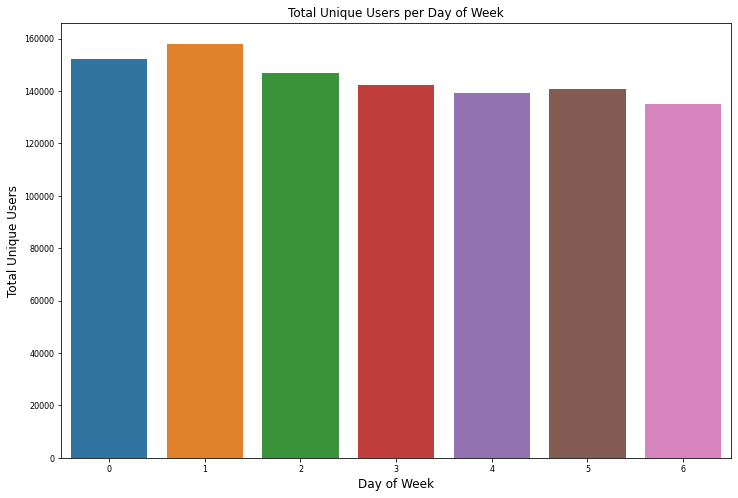

In [25]:
temp_df = orders.groupby('order_dow')['user_id'].nunique()

fig, ax = plt.subplots(figsize = (12,8))
ax = sns.barplot(x = temp_df.index, y = temp_df.values)
ax.set_xlabel('Day of Week', size = 12)
ax.set_ylabel('Total Unique Users', size = 12)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_title('Total Unique Users per Day of Week')
fig.savefig('Total Unique Users per Day of Week.png')
plt.show()

0과 1일 때 나머지 요일보다 많은 주문이 발생하며 중복 주문을 제외한 이용 고객수는 요일별 큰 차이를 보이지 않는다.  
0~1은 주말로 추측해도 좋을 것 같다.  
주말은 평일에 비해 33% 주문이 증가한다.  

### order_hour_of_day
주문이 발생한 시간대(0~24h)

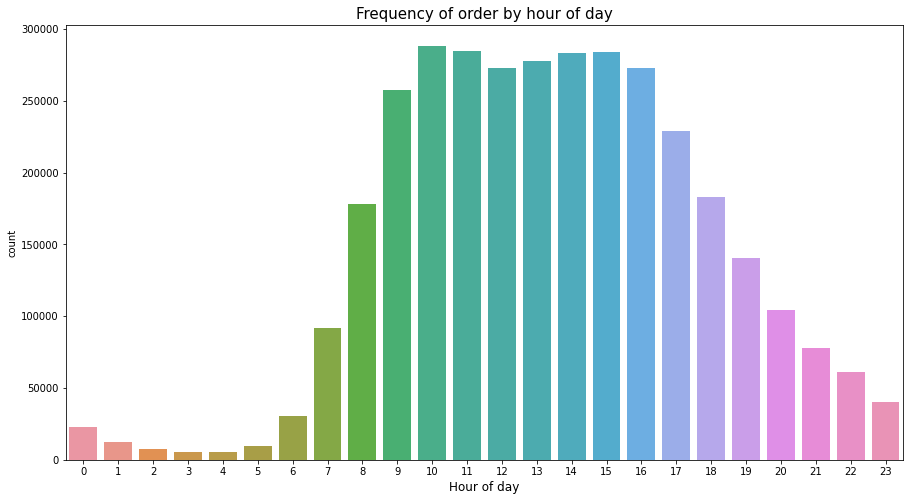

In [26]:
plt.figure(figsize=(15, 8))
sns.countplot(x='order_hour_of_day', data=orders)
plt.title("Frequency of order by hour of day", fontsize=15)
plt.xlabel('Hour of day', fontsize=12)
plt.show()

대부분의 주문은 9시부터 17시 사이에 발생하는 것을 볼 수 있다.

### days_since_prior_order

이전 주문과 현재 주문의 간격(d)을 나타낸다. 0부터 최대 30일까지 있다.

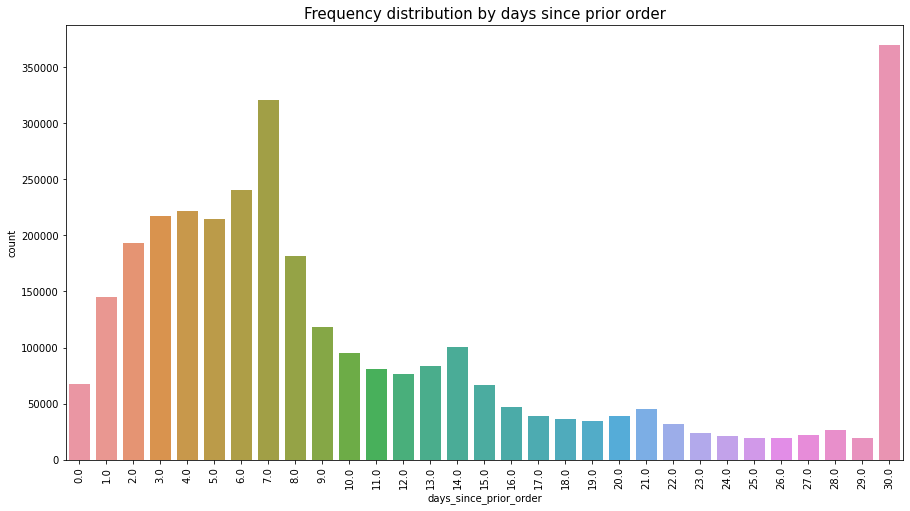

In [27]:
plt.figure(figsize=(15,8))
sns.countplot(x='days_since_prior_order', data=orders)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

주문 간격이 30일인 고객이 가장 많고 대체로 8일 이내에 재구매가 많이 일어난다.
14, 21, 28일 등 7일 주기로 다시 구매하는 고객들도 보인다.

## priors

마지막 주문을 제외한 모든 주문 별로 구매 내역을 확인할 수 있다. 

총 row 수는 32,434,489개다.

- `order_id` : 주문 식별번호 (외래 키)

- `product_id` : 제품 식별번호 (외래 키)

- `add_to_cart_order` : 제품이 장바구니에 담긴 순서

- `reordered` : 재구매 여부 (0, 1)


* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise
where SET is one of the four following evaluation sets (eval_set in orders):

In [28]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [29]:
# priors 결측치 확인
priors.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [30]:
prior_df = df[df.eval_set == 'prior']
prior_df.head()

,user_id,order_number,order_id,product_id,product_name,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,aisle,department_id,department,eval_set
0,1,1,2539329,196.0,Soda,1.0,0.0,2,8,NaN,77.0,soft drinks,7.0,beverages,prior
1,1,1,2539329,14084.0,Organic Unsweetened Vanilla Almond Milk,2.0,0.0,2,8,NaN,91.0,soy lactosefree,16.0,dairy eggs,prior
2,1,1,2539329,12427.0,Original Beef Jerky,3.0,0.0,2,8,NaN,23.0,popcorn jerky,19.0,snacks,prior
3,1,1,2539329,26088.0,Aged White Cheddar Popcorn,4.0,0.0,2,8,NaN,23.0,popcorn jerky,19.0,snacks,prior
4,1,1,2539329,26405.0,XL Pick-A-Size Paper Towel Rolls,5.0,0.0,2,8,NaN,54.0,paper goods,17.0,household,prior


### 한번의 주문에 구매된 제품 수

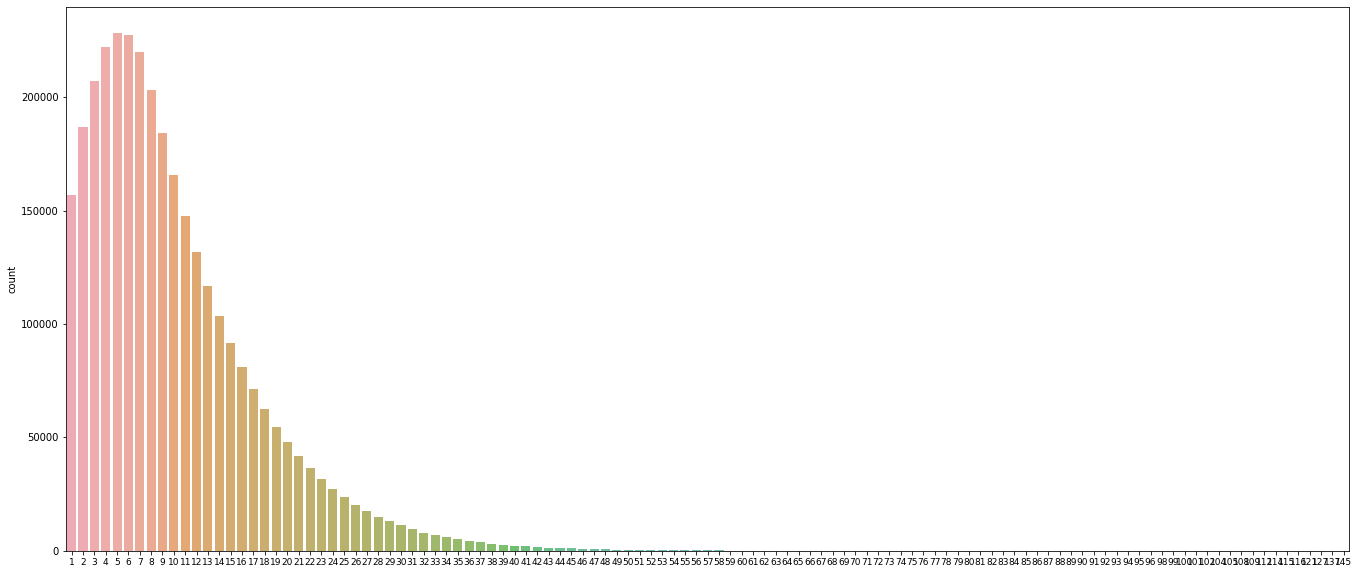

In [31]:
data = priors.groupby('order_id')['add_to_cart_order'].max()
plt.figure(figsize=(23,10))
sns.countplot(data.values.astype(np.uint8), alpha=0.8)
plt.xticks(fontsize=9)
plt.show()

In [32]:
data.describe().astype(np.uint32)

count    3214874
mean          10
std            7
min            1
25%            5
50%            8
75%           14
max          145
Name: add_to_cart_order, dtype: uint32

고객들은 평균적으로 한번에 10개의 물건을 주문한다.  
가장 많이 구매한 고객은 145개를 한번에 주문했다.

### 장비구니에 제품에 담긴 순서 별 재구매 율

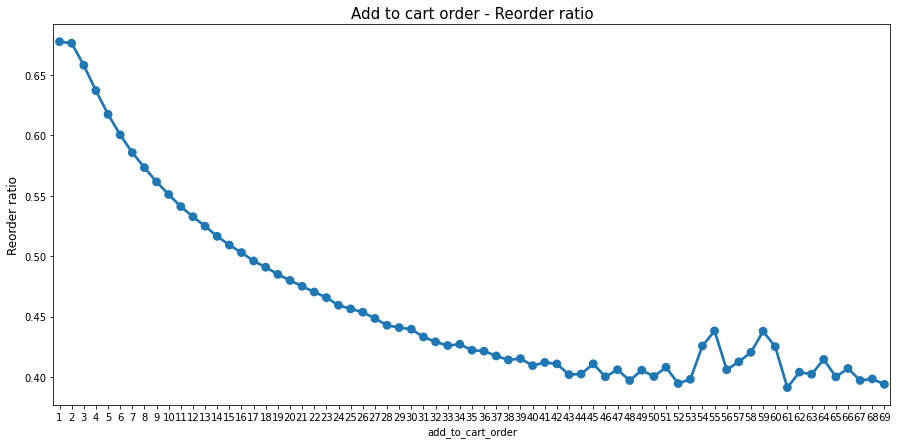

In [33]:
data = priors[priors['add_to_cart_order'] < 70].groupby('add_to_cart_order')['reordered'].mean()

plt.figure(figsize=(15, 7))
sns.pointplot(data.index, data.values)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.ylabel('Reorder ratio', fontsize=12)
plt.show()

장바구니에 담긴 순서에 따라 재구매율에 큰 차이가 있는 것을 확인할 수 있다.  
다시 구매할 제품을 먼저 장바구니에 담는 것으로 보인다.


### 주문 별 재주문 제품 비율

In [34]:
(priors.groupby('order_id')['reordered'].sum() >= 1).astype(np.uint8).value_counts() / priors.order_id.nunique()

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [35]:
# 모든 첫 주문을 뺀 주문 별 재주문 제품 포함 비율 (모든 첫 주문은 재주문 제품이 포함되지 않기 때문)
(prior_df[prior_df.order_number != 1].groupby('order_id')['reordered'].sum() >= 1).astype(np.uint8).value_counts() / prior_df[prior_df.order_number != 1].order_id.nunique()

1    0.939407
0    0.060593
Name: reordered, dtype: float64

고객들의 첫 주문에 포함된 제품들은 전부 `reordered`가 아닌 것으로 나타난다.  
따라서 전체 주문 중 유저의 첫 주문을 제외한 주문에서 재주문 제품을 확인해보면 전체의 93.9%가 재주문 제품이다. 
대부분의 고객은 이전에 구매했던 제품을 다시 구매하는 것으로 보인다.

### reordered

In [36]:
print(f"총 판매 제품 수 : {priors.shape[0]}")
print(f"재구매 제품 수 : {priors.reordered.sum()}")
print(f"재구매 제품 비율 : {(priors.reordered.sum() / priors.shape[0]) * 100:.1f}%")

총 판매 제품 수 : 32434489
재구매 제품 수 : 19126536
재구매 제품 비율 : 59.0%


# 추가할 것

In [37]:
# 첫 주문을 제외한 총 판매 제품 중 재구매 제품의 비율

print(
print(
print(

SyntaxError: unexpected EOF while parsing (1232564118.py, line 5)

In [ ]:
# 재구매 제품의 비율 시각화

전체 판매량 중 재구매 제품의 비율은 59%이다.

## products & aisles & departments

`products` (50k rows):

* `product_id`: 제품 식별번호
* `product_name`: 제품의 이름
* `aisle_id`: 외래 키
* `aisle`: 소분류 카테고리명
* `department_id`: 외래 키
* `department`: 대분류 카테고리명


In [ ]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
# 결측치 확인
products.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

### product_id & aisle_od & department_id

In [41]:
PATH2 = 'J:/.shortcut-targets-by-id/1CmFyW0xQERiGa58Updu5HVh0niAWQSBA/prepared/'
prod_feats = pd.read_pickle(PATH2 + 'prod_feats.pkl')

In [42]:
print(f"총 제품 수 : {products.product_id.nunique()}")
print(f"총 소분류 개수 : {products.aisle_id.nunique()}")
print(f"총 대분류 개수 : {products.department_id.nunique()}")

총 제품 수 : 49688
총 소분류 개수 : 134
총 대분류 개수 : 21


### 많이 팔린 제품 랭킹 TOP 20

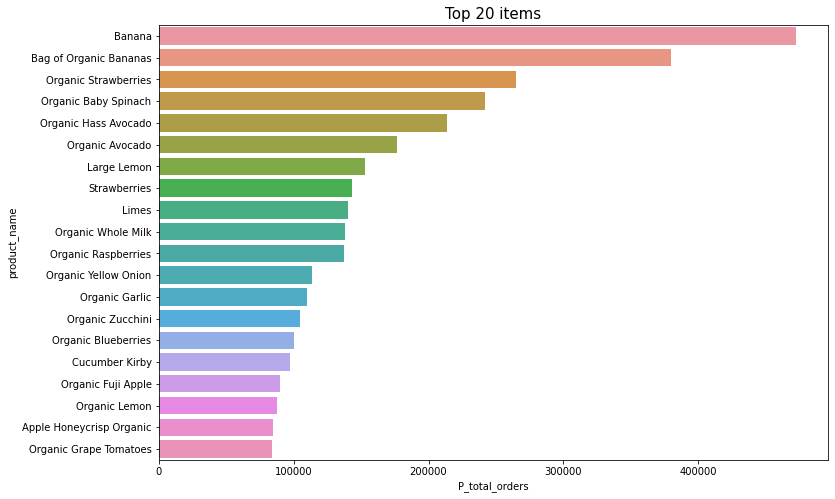

In [43]:
# 많이 팔린 제품 랭킹 TOP 20 리스트
plt.figure(figsize=(12, 8))
plt.title('Top 20 items', fontsize=15)
sns.barplot(prod_feats.P_total_orders.astype(np.object0)[0:20], prod_feats.product_name.astype(np.object0)[0:20], label='total')
plt.show()

 Top20 제품의 대부분이 과일, 채소 등 신선식품이며 판매량 1,2위 모두 바나나로 가장 많이 팔렸다. Oragnic 제품이 상위권에 많이 분포한 것을 알 수 있다.

### 전제 판매량 중 판매랭킹 상위 제품의 비중

전체 판매량 : 32434489 건


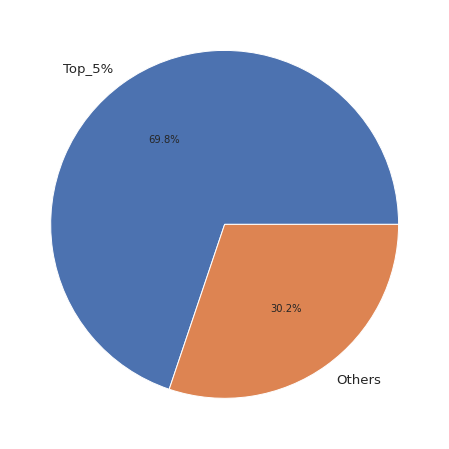

In [ ]:
# TOP5 제품의 비중
top_five = int(prod_feats.shape[0] * 0.05)
print('전체 판매량 :', prior_df.shape[0], '건')
plt.figure(figsize=(10, 8))
pd.Series({'Top_5%':prod_feats.head(top_five)['P_total_orders'].sum(), 'Others': prior_df.shape[0] - prod_feats.head(top_five)['P_total_orders'].sum()}).plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.show()

전체 판매량 : 32434489 건


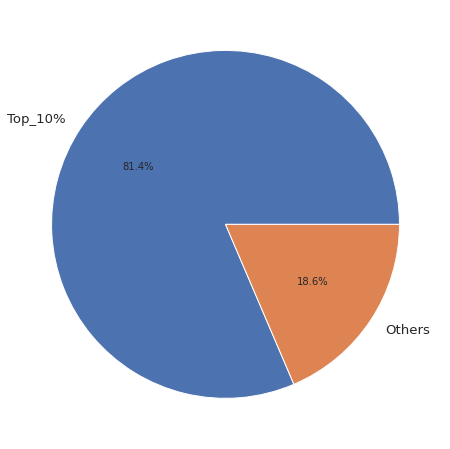

In [ ]:
# TOP 10 제품의 비중
top_ten = int(prod_feats.shape[0] * 0.1) # 4967
print('전체 판매량 :', prior_df.shape[0], '건')
plt.figure(figsize=(10, 8))
pd.Series({'Top_10%':prod_feats.head(top_ten)['P_total_orders'].sum(), 'Others': prior_df.shape[0] - prod_feats.head(top_ten)['P_total_orders'].sum()}).plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.show()

전체 판매량 : 32434489 건


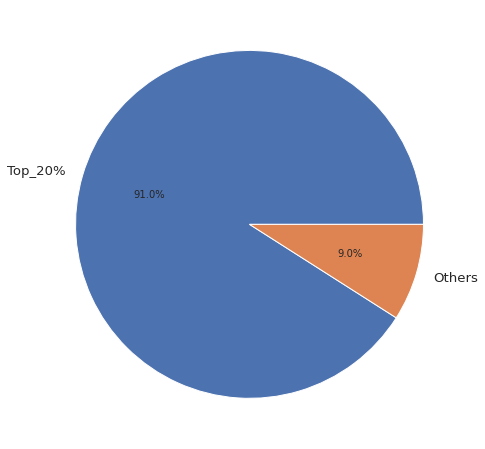

In [ ]:
# TOP 20 제품의 비중
top_20 = int(prod_feats.shape[0] * 0.20)
print('전체 판매량 :', prior_df.shape[0], '건')
plt.figure(figsize=(10, 8))
pd.Series({'Top_20%':prod_feats.head(top_20)['P_total_orders'].sum(), 'Others': prior_df.shape[0] - prod_feats.head(top_20)['P_total_orders'].sum()}).plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.show()

판매량 상위권 제품들이 전체 판매량에서 얼마를 차지하는지 확인한 결과 상위 판매량 20% 제품이 전체 판매량 91%를 차지한다.

### 전체 상품 중 aisle에 분류된 상품의 개수와 아일별 판매량

In [ ]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]
grouped

In [ ]:
grouped = df.groupby("aisle")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped = grouped.sort_values(by='Total_products', ascending=False)[:20]
grouped

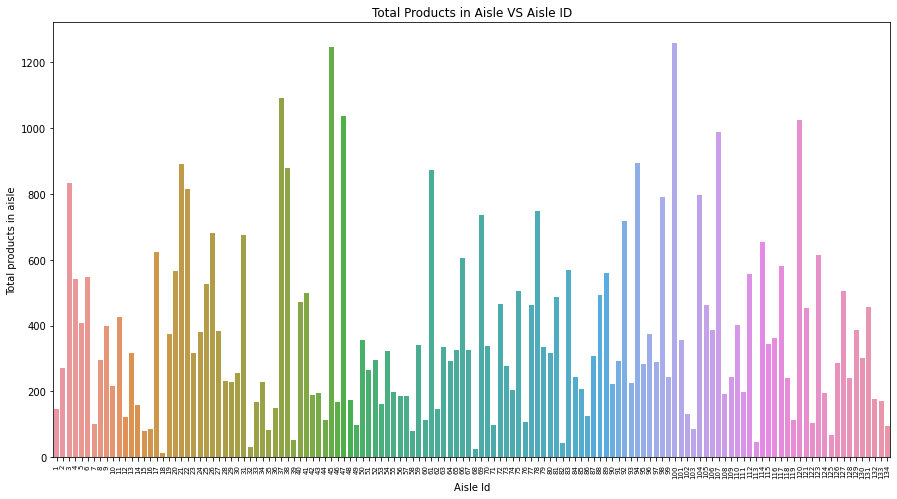

In [ ]:
temp_df = products.groupby('aisle_id')['product_id'].count()

fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(x = temp_df.index, y = temp_df.values)
ax.set_xlabel('Aisle Id')
ax.set_ylabel('Total products in aisle')
ax.xaxis.set_tick_params(rotation=90, labelsize = 7)
ax.set_title('Total Products in Aisle VS Aisle ID', size = 12)
fig.savefig('Total Products in Aisle VS Aisle ID.png')

Text(0.5, 1.0, 'Total order volume by Aisle')

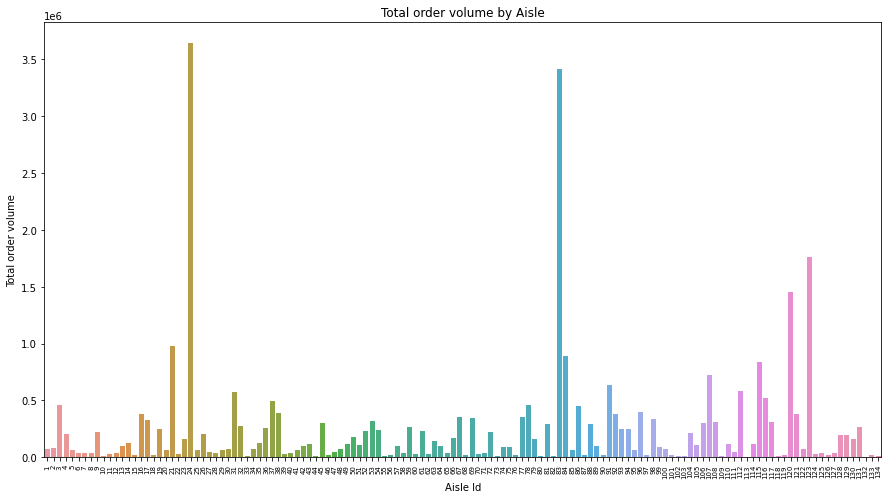

In [44]:
temp_df = prod_feats.groupby('aisle_id').P_total_orders.sum()

fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(x = temp_df.index, y = temp_df.values)
ax.set_xlabel('Aisle Id')
ax.set_ylabel('Total order volume')
ax.xaxis.set_tick_params(rotation=90, labelsize = 7)
ax.set_title('Total order volume by Aisle', size = 12)
# fig.savefig('Total Products in Aisle VS Aisle ID.png')

### 전체 상품 중 department에 분류된 상품의 개수와 아일별 판매량

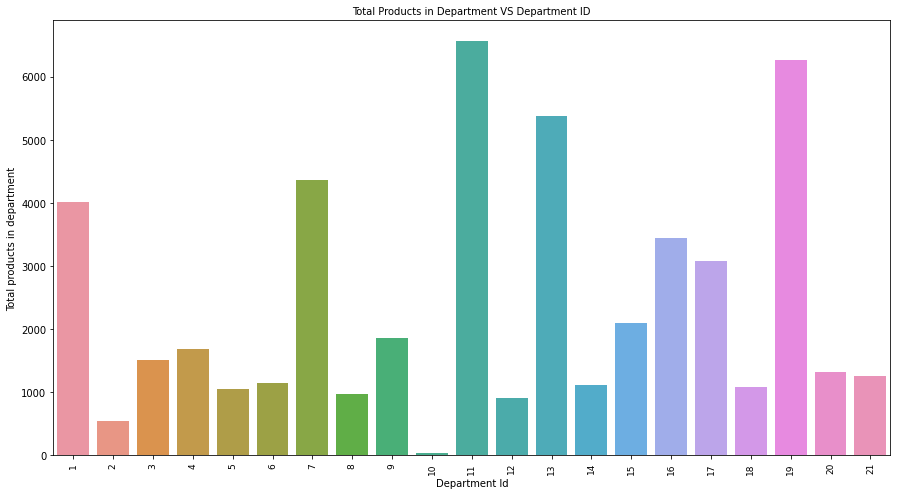

In [ ]:
temp_df = products.groupby('department_id')['product_id'].count()

fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(x = temp_df.index, y = temp_df.values)
ax.set_xlabel('Department Id')
ax.set_ylabel('Total products in department')
ax.xaxis.set_tick_params(rotation=90, labelsize = 9)
ax.set_title('Total Products in Department VS Department ID', size = 10)
fig.savefig('Total Products in Department VS Department ID.png')

Text(0.5, 1.0, 'Total order volume by Department')

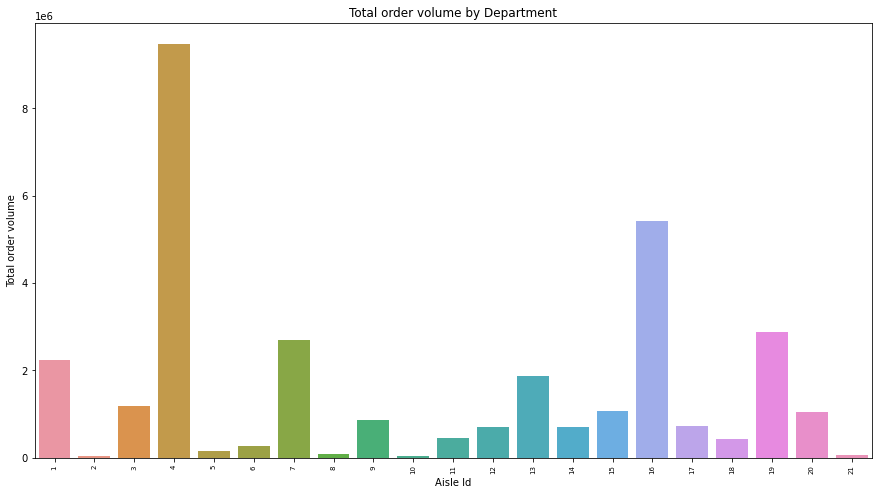

In [ ]:
temp_df = prod_feats.groupby('department_id').P_total_orders.sum()

fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(x = temp_df.index, y = temp_df.values)
ax.set_xlabel('Aisle Id')
ax.set_ylabel('Total order volume')
ax.xaxis.set_tick_params(rotation=90, labelsize = 7)
ax.set_title('Total order volume by Department', size = 12)
# fig.savefig('Total Products in Aisle VS Aisle ID.png')